In [4]:
!pip install textblob

In [3]:
import pandas as pd
import numpy as np
import re
import string,time
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")

In [6]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [7]:
df.shape

(50000, 2)

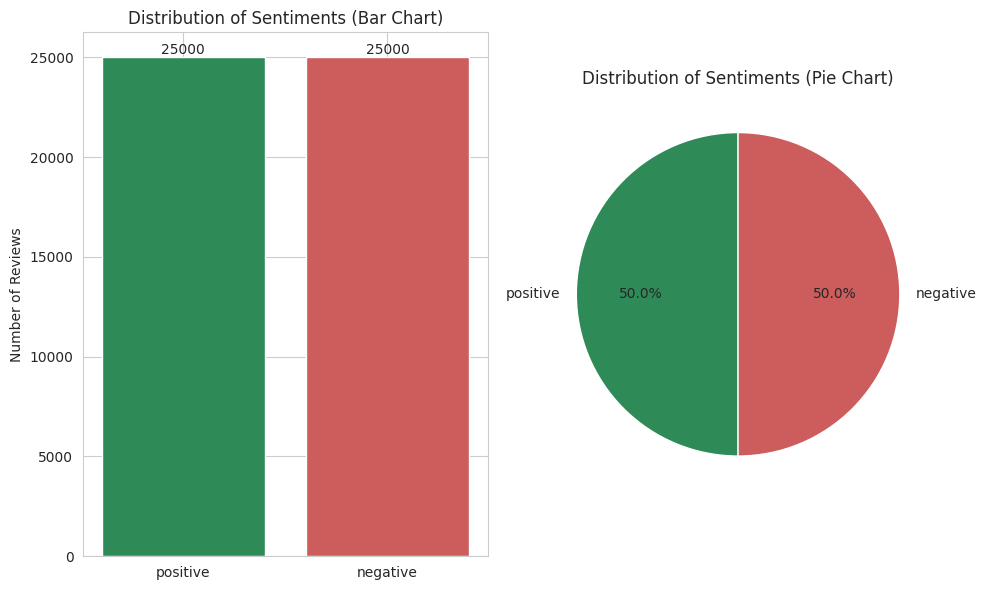

In [8]:
# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot
sentiment_counts = df['sentiment'].value_counts()
colors = ['#2E8B57', '#CD5C5C', '#FFD700'] # Green, Red, Gold

plt.subplot(1, 2, 1)
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.title('Distribution of Sentiments (Bar Chart)')
plt.ylabel('Number of Reviews')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{int(height)}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Distribution of Sentiments (Pie Chart)')

plt.tight_layout()
plt.show()

In [9]:
df['review']=df['review'].str.lower()

In [10]:
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,i am a catholic taught in parochial elementary...,negative
49998,i'm going to have to disagree with the previou...,negative


In [11]:
def remove_html_tag(text):
    patten = re.compile('<.*?>')
    return patten.sub(r"",text)

In [12]:
df["review"] = df["review"].apply(remove_html_tag)

In [13]:
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,i am a catholic taught in parochial elementary...,negative
49998,i'm going to have to disagree with the previou...,negative


In [14]:
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r"",text)

In [15]:
df["review"] = df["review"].apply(remove_url)

In [16]:
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,i am a catholic taught in parochial elementary...,negative
49998,i'm going to have to disagree with the previou...,negative


In [17]:
exclude = string.punctuation

In [18]:
def remove_punc(text):
    for char in exclude:
        text = text.replace(char,"")
    return text

In [19]:
df["review"] = df["review"].apply(remove_punc)

In [20]:
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,i am a catholic taught in parochial elementary...,negative
49998,im going to have to disagree with the previous...,negative


In [21]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A** Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A**",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A** Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That Feeling When",
    "MFW": "My Face When",
    "MRW": "My Reaction When",
    "IFYP": "I Feel Your Pain",
    "LOL": "Laughing Out Loud",
    "TNTL": "Trying Not To Laugh",
    "JK": "Just Kidding",
    "IDC": "I Don’t Care",
    "ILY": "I Love You",
    "IMU": "I Miss You",
    "ADIH": "Another Day In Hell",
    "ZZZ": "Sleeping, Bored, Tired",
    "WYWH": "Wish You Were Here",
    "TIME": "Tears In My Eyes",
    "BAE": "Before Anyone Else",
    "FIMH": "Forever In My Heart",
    "BSAAW": "Big Smile And A Wink",
    "BWL": "Bursting With Laughter",
    "BFF": "Best Friends Forever",
    "CSL": "Can’t Stop Laughing"
}

In [22]:
def chat_conversion(text):
    new_text = []
    for w in text.split():
        word = w.strip(string.punctuation)  # Remove surrounding punctuation
        if word.upper() in chat_words:
            new_text.append(chat_words[word.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [23]:
df["review"] = df["review"].apply(chat_conversion)

In [24]:
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend Te...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the Tears In My Eyes of...,positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,i am a catholic taught in parochial elementary...,negative
49998,im going to have to disagree with the previous...,negative


In [25]:
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(df["review"])
y = df["sentiment"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [27]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (40000, 220905)
Test shape: (10000, 220905)


In [28]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

In [29]:
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted")
    rec = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })

In [30]:
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision  Recall  F1-score
0  Logistic Regression    0.8928   0.893226  0.8928  0.892755
1          Naive Bayes    0.8670   0.867132  0.8670  0.866999
2                  SVM    0.8936   0.893724  0.8936  0.893583
3        Random Forest    0.8545   0.854530  0.8545  0.854502


In [31]:
clf = LogisticRegression(max_iter=10000,penalty='l2')
clf.fit(X_train, y_train)


LogisticRegression(max_iter=10000)

In [32]:
acc = accuracy_score(y_test, clf.predict(X_test)) * 100
print(f"Logistic Regression model accuracy: {acc:.2f}%")

Logistic Regression model accuracy: 89.28%


In [33]:
clf.predict(vectorizer.transform(["This movie was a complete disappointment. The storyline was predictable, the acting felt forced, and the pacing was painfully slow. The special effects looked outdated, and the ending made no sense at all. Honestly, it was a waste of time and money"]))


array(['negative'], dtype=object)

In [34]:
clf.predict(vectorizer.transform(["This movie was an absolute delight from start to finish! The storyline was engaging and beautifully paced, keeping me hooked throughout. The performances were powerful and heartfelt, with each actor bringing so much depth to their character. The cinematography and music added a magical touch, making every scene memorable. It’s one of those films that leaves you inspired and smiling long after the credits roll. A must-watch for anyone who loves great storytelling and unforgettable moments!"]))

array(['positive'], dtype=object)